# QAOA for Portfolio Optimization, Toy Example
In this notebook a small portfolio optimization problem is solved using QAOA. We incorporate the fixed budget constraint using two different methods, namely the penalty method and the XY-mixer method. The quantum circuit used is shown for both methods and the approximation ratio for depth = 1 is computed for the two methods.

# Import neceassry modules

In [1]:
try:
    from qaoa import QAOA, problems, mixers, initialstates
except ImportError:
    from qaoa import QAOA, problems, mixers, initialstates



In [2]:
from asset_loader import AssetData

import os
import sys

from qaoa.util.plotroutines import *
from matplotlib import pyplot as pl

import itertools

# Creating problem instance

/home/havahol/playground/quantumComputing-wls/QAOA/examples/PortfolioOptimization/asset_loader.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


array([ 2.51714041e-03, -6.60209726e-04, -1.70699934e-03,  7.30592102e-04,
       -7.68369448e-05,  8.56893545e-04, -6.84333999e-03, -1.94220999e-03,
        4.44702531e-03, -4.76239370e-04, -3.90803496e-03,  9.03679818e-04])

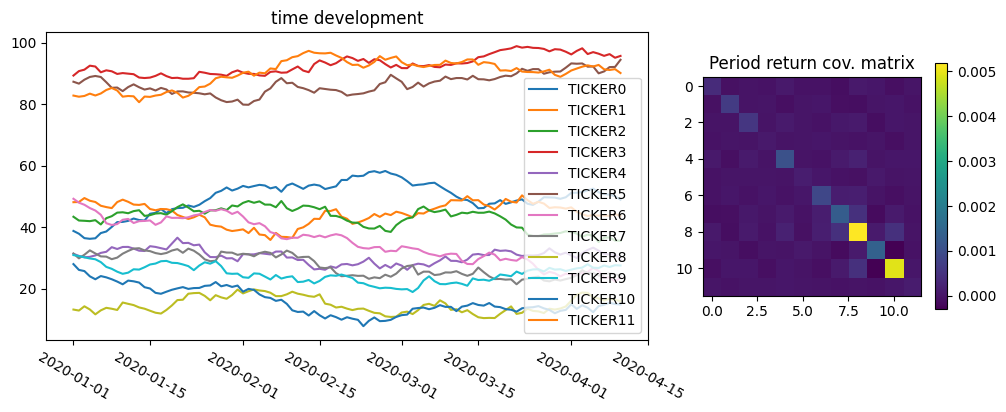

In [3]:
number_of_assets = 12
budget = 4

filename = os.path.join(
    "data", "qiskit_finance_seeds.npz"
)  # filename of file containing time series of
# non-crashing stocks.
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()
assets.exp_return

In [4]:
from math import comb
print("Total state space: ", 2**number_of_assets)
print("Feasible state space: ", comb(number_of_assets, budget))

Total state space:  4096
Feasible state space:  495


# Creating QAOA instances for both methods
Below we create a QAOA instance for both the penalty method and for the XY-mixer method.
The gamma_scale parameter is used to adjust the search range for the gamma parameter. 

For information about the scale parameter see Sebastian Brandhofer et al. “Benchmarking the performance of portfolio optimization with QAOA”. In: Quantum Information Processing 22.1 (2023), page 25-26)
or Zichang He et al. Alignment between Initial State and Mixer Improves QAOA Performance for 
Constrained Portfolio Optimization page 7 (2023)

In [5]:
def get_problem(penalty=None):
    if not penalty:
        return problems.PortfolioOptimization(
            risk=0.5 * gamma_scale,
            budget=budget,
            cov_matrix=assets.cov_matrix,
            exp_return=assets.exp_return * gamma_scale,
        )
    else:
        return problems.PortfolioOptimization(
            risk=0.5 * gamma_scale,
            budget=budget,
            cov_matrix=assets.cov_matrix,
            exp_return=assets.exp_return * gamma_scale,
            penalty=penalty,
        )

In [6]:
gamma_scale = 50  # Adjusts the search range for the gamma parameter
qaoa_penalty = {}
qaoa_XYmixer_chain = {}
qaoa_XYmixer_ring = {}
qaoa_Grover = {}
for cvar in [0.1, 1]:
    qaoa_penalty[cvar] = QAOA(
        initialstate=initialstates.Plus(),
        problem=get_problem(4 * gamma_scale),
        mixer=mixers.X(),
        cvar=cvar,
    )

    qaoa_XYmixer_chain[cvar] = QAOA(
        initialstate=initialstates.Dicke(budget),
        problem=get_problem(),
        mixer=mixers.XY(case="chain"),
        cvar=cvar,
    )

    qaoa_XYmixer_ring[cvar] = QAOA(
        initialstate=initialstates.Dicke(budget),
        problem=get_problem(),
        mixer=mixers.XY(case="ring"),
        cvar=cvar,
    )

    qaoa_Grover[cvar] = QAOA(
        initialstate=initialstates.Dicke(budget),
        problem=get_problem(),
        mixer=mixers.Grover(initialstates.Dicke(budget)),
        cvar=cvar,
    )

In [7]:
for cvar in [0.1, 1]:
    print(qaoa_penalty[cvar].problem.brute_force_solve())
    print(qaoa_XYmixer_chain[cvar].problem.brute_force_solve())
    print(qaoa_XYmixer_ring[cvar].problem.brute_force_solve())
    print(qaoa_Grover[cvar].problem.brute_force_solve())
best_sol = qaoa_Grover[cvar].problem.brute_force_solve()

100001001001
100001001001
100001001001
100001001001
100001001001
100001001001
100001001001
100001001001


In [8]:
qaoa_Grover[1].initialstate.N_qubits

12

Sample and plot the cost landscape for the different methods

2025-09-13 21:13:12 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:12 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:12 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:12 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:27 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:27 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'penalty method')

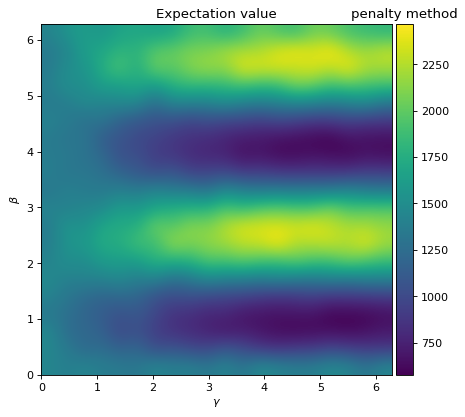

In [9]:
qaoa_penalty[1].sample_cost_landscape()
plot_E(qaoa_penalty[1])
pl.title("penalty method")

2025-09-13 21:13:28 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:29 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:29 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:29 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:41 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:41 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'XY mixer chain')

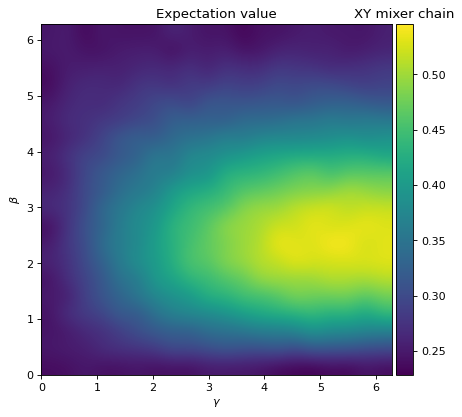

In [10]:
qaoa_XYmixer_chain[1].sample_cost_landscape()
plot_E(qaoa_XYmixer_chain[1])
pl.title("XY mixer chain")

2025-09-13 21:13:42 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:42 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:42 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:42 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:55 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:55 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'XY mixer ring')

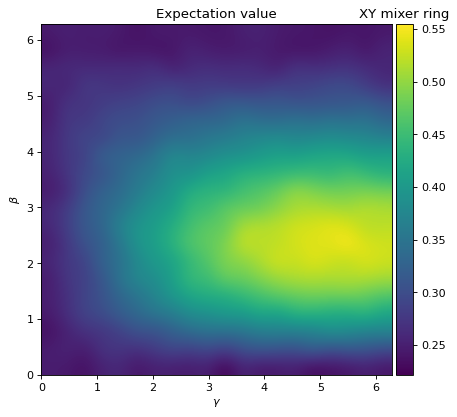

In [11]:
qaoa_XYmixer_ring[1].sample_cost_landscape()
plot_E(qaoa_XYmixer_ring[1])
pl.title("XY mixer ring")

2025-09-13 21:13:56 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:57 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:57 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:13:57 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:14 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:14 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


Text(0.5, 1.0, 'Grover mixer')

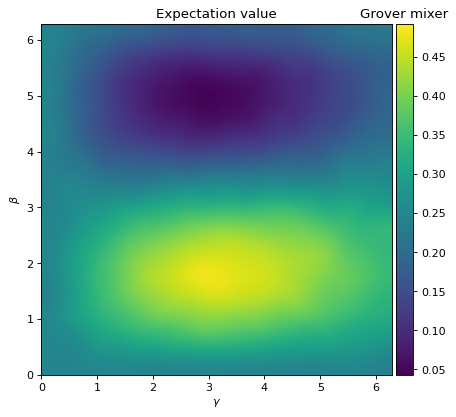

In [12]:
qaoa_Grover[1].sample_cost_landscape()
plot_E(qaoa_Grover[1])
pl.title("Grover mixer")

# Search for the best parameters at depth = 1 and plot histogram for both methods
The values for the parameters $\gamma$ and $\beta$ are found by the optimizer, and the circuit is then measured 2048 times. The measurement outcome is seen in the histogram below. One can see that all the measruement outcomes (pink) for XY-mixer method is in the feasible subspace, while for the penalty method some measured strings are infeasible.

In [13]:
maxdepth = 10
for cvar in [0.1, 1]:
    qaoa_penalty[cvar].optimize(depth=maxdepth)
    qaoa_XYmixer_chain[cvar].optimize(depth=maxdepth)
    qaoa_XYmixer_ring[cvar].optimize(depth=maxdepth)
    qaoa_Grover[cvar].optimize(depth=maxdepth)

2025-09-13 21:14:15 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:15 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:15 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape


2025-09-13 21:14:15 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:52 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:52 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2025-09-13 21:14:54 [info     ] cost(depth 1 = -0.22263414794515482 file=qaoa.qaoa func=optimize
2025-09-13 21:14:58 [info     ] cost(depth 2 = -0.08334081300163712 file=qaoa.qaoa func=optimize
2025-09-13 21:15:03 [info     ] cost(depth 3 = -0.15620272656452416 file=qaoa.qaoa func=optimize
2025-09-13 21:15:12 [info     ] cost(depth 4 = -0.18702479771537409 file=qaoa.qaoa func=optimize
2025-09-13 21:15:22 [info     ] cost(depth 5 = -0.07909257580957563 file=qaoa.qaoa func=optimize
2025-09-13 21:15:34 [info     ] cost(depth 6 = -0.05294063045171739 file=qaoa.qaoa func=optimize
2025-09-13 21:15:50 [info     ] cost(depth 7 = -0.1914334290967913 file=qaoa.qaoa func=optimize
2025

In [14]:
min_cost, max_cost = qaoa_Grover[1].problem.computeMinMaxCosts()
min_cost, max_cost

(np.float64(-0.29191609262381646), np.float64(0.9214724310800932))

The approximation ratio plotted is for feasible states only, i.e., infeasible solutions are neglected.

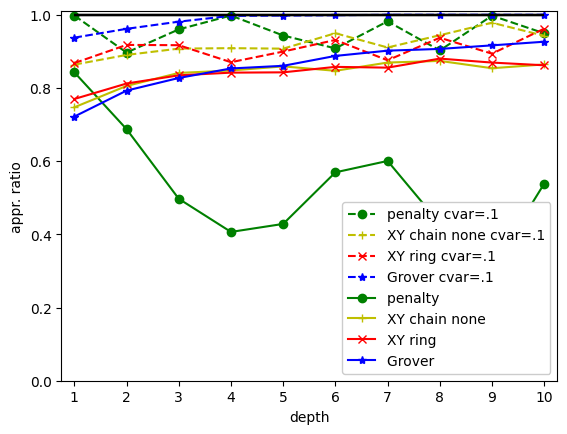

In [15]:
shots = 1024
fig = pl.figure()
for cvar in [0.1, 1]:
    if cvar == 1:
        ls = "-"
        la = " "
    else:
        ls = "--"
        la = " cvar=.1"
    plot_ApproximationRatio(
        qaoa_penalty[cvar],
        maxdepth,
        mincost=min_cost,
        maxcost=max_cost,
        label="penalty" + la,
        style="og" + ls,
        fig=fig,
        shots=shots,
    )
    plot_ApproximationRatio(
        qaoa_XYmixer_chain[cvar],
        maxdepth,
        mincost=min_cost,
        maxcost=max_cost,
        label="XY chain none" + la,
        style="+y" + ls,
        fig=fig,
        shots=shots,
    )
    plot_ApproximationRatio(
        qaoa_XYmixer_ring[cvar],
        maxdepth,
        mincost=min_cost,
        maxcost=max_cost,
        label="XY ring" + la,
        style="xr" + ls,
        fig=fig,
        shots=shots,
    )
    plot_ApproximationRatio(
        qaoa_Grover[cvar],
        maxdepth,
        mincost=min_cost,
        maxcost=max_cost,
        label="Grover" + la,
        style="*b" + ls,
        fig=fig,
        shots=shots,
    )

Since infeasible states are neglected in the approximation ratio for the penalty method (XY-mixers and the Grover mixer preserve the feasible subspace), we additionally plot the success probability.

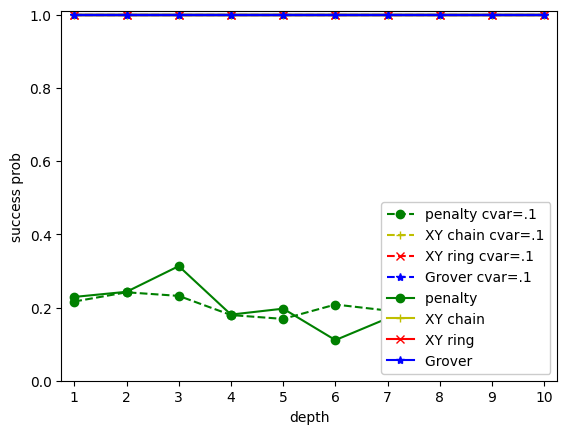

In [16]:
fig = pl.figure()
for cvar in [0.1, 1]:
    if cvar == 1:
        ls = "-"
        la = " "
    else:
        ls = "--"
        la = " cvar=.1"
    plot_successprob(
        qaoa_penalty[cvar], maxdepth, label="penalty" + la, style="og" + ls, fig=fig
    )
    plot_successprob(
        qaoa_XYmixer_chain[cvar],
        maxdepth,
        label="XY chain" + la,
        style="+y" + ls,
        fig=fig,
    )
    plot_successprob(
        qaoa_XYmixer_ring[cvar],
        maxdepth,
        label="XY ring" + la,
        style="xr" + ls,
        fig=fig,
    )
    plot_successprob(
        qaoa_Grover[cvar], maxdepth, label="Grover" + la, style="*b" + ls, fig=fig
    )

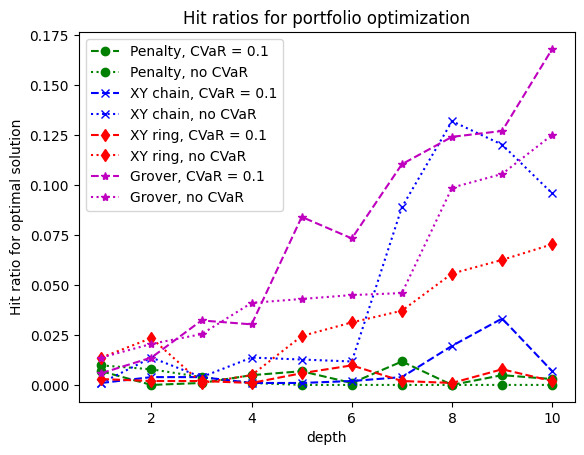

In [87]:
qaoas = [qaoa_penalty, qaoa_XYmixer_chain, qaoa_XYmixer_ring, qaoa_Grover]

fig = plt.Figure()
labels_start = ["Penalty", "XY chain", "XY ring", "Grover"]
labels_end = [", CVaR = 0.1", ", no CVaR"]
styles = [['o--g', 'x--b', 'd--r', '*--m'],
           ['o:g',  'x:b',  'd:r',  '*:m']]
cvars = [0.1, 1]
for i in range(4):
    for c in range(2):
        plot_optimalHitRatios(
            qaoas[i][cvars[c]], best_sol, shots=1024, 
            style=styles[c][i], label=labels_start[i]+labels_end[c], fig=fig,
            title="Hit ratios for portfolio optimization")


In [20]:
printBestHistogramEntries(qaoa_Grover[0.1], best_sol)

Classical best result:  ('100001001001', np.float64(0.29191609262381646))
 --> points to the classical solution 
   * marks feasible solutions 
Results for depth 1 using best angles:
1	  * 100010001001, 0.20391838811279903,   11
2	  * 010001001001, 0.13677285824277996,   10
3	  * 111000001000, 0.06383479995630889,   9
4	  * 100100001100, 0.17839830219718159,   9
5	  * 001000100011, -0.7383692533431134,   9
6	  * 100000001101, 0.1851075628704783,   9
7	  * 001100001001, 0.06922392330605595,   8
8	  * 110100000001, 0.15020659907178668,   8
9	  * 100101001000, 0.2865532852480931,   8
10	  * 100011010000, -0.003042407620646198,   8
Found best classical solution with 5 shots (rank: 62)
Results for depth 2 using best angles:
1	  * 110001001000, 0.20859074549301335,   22
2	  * 001000110010, -0.9214724310800932,   22
3	  * 100100001001, 0.2860836024471489,   16
4	  * 001000100110, -0.8165740554530807,   16
5	  * 010000110010, -0.8672864936047971,   15
6	  * 110000001001, 0.21043734347389056,  

In [26]:
printBestHistogramEntries(qaoa_Grover[1], best_sol, shots=1024*100)

Classical best result:  ('100001001001', np.float64(0.29191609262381646))
 --> points to the classical solution 
   * marks feasible solutions 
Results for depth 1 using best angles:
1	  * 100100001001, 0.2860836024471489,   747
2	--> 100001001001, 0.29191609262381646,   740
3	  * 110000001001, 0.21043734347389056,   713
4	  * 100101001000, 0.2865532852480931,   686
5	  * 110100001000, 0.20217706401511265,   669
6	  * 110001001000, 0.20859074549301335,   661
7	  * 000101001001, 0.21423056386617292,   655
8	  * 100110001000, 0.20092220059685084,   653
9	  * 100011001000, 0.2064904689689816,   649
10	  * 100001001100, 0.18086276064306012,   648
Found best classical solution with 740 shots (rank: 2)
Results for depth 2 using best angles:
1	  * 100100001001, 0.2860836024471489,   1529
2	--> 100001001001, 0.29191609262381646,   1519
3	  * 100101001000, 0.2865532852480931,   1451
4	  * 100101000001, 0.2348935638495645,   1400
5	  * 110000001001, 0.21043734347389056,   1314
6	  * 000101001001

In [28]:
printBestHistogramEntries(qaoa_penalty[1], best_sol, shots=1024*100)

Classical best result:  ('100001001001', np.float64(0.29191609262381646))
 --> points to the classical solution 
   * marks feasible solutions 
Results for depth 1 using best angles:
1	    100101001001, -199.6706134964309,   1063
2	  * 100100001001, 0.2860836024471489,   930
3	--> 100001001001, 0.29191609262381646,   884
4	    100000001001, -199.75150387356766,   882
5	  * 100101001000, 0.2865532852480931,   869
6	    100000000000, -1799.8835503155838,   857
7	    100001001000, -199.75082901230988,   842
8	    100000001000, -799.7944959399313,   826
9	  * 100101000001, 0.2348935638495645,   807
10	    100000000001, -799.8416240122584,   803
Found best classical solution with 884 shots (rank: 3)
Results for depth 2 using best angles:
1	    000000000000, -3200.0,   526
2	    000000001000, -1799.9072058858792,   474
3	    100000001000, -799.7944959399313,   432
4	    100000000000, -1799.8835503155838,   423
5	    000000001001, -799.8636987141767,   355
6	    000000000001, -1799.9575585913

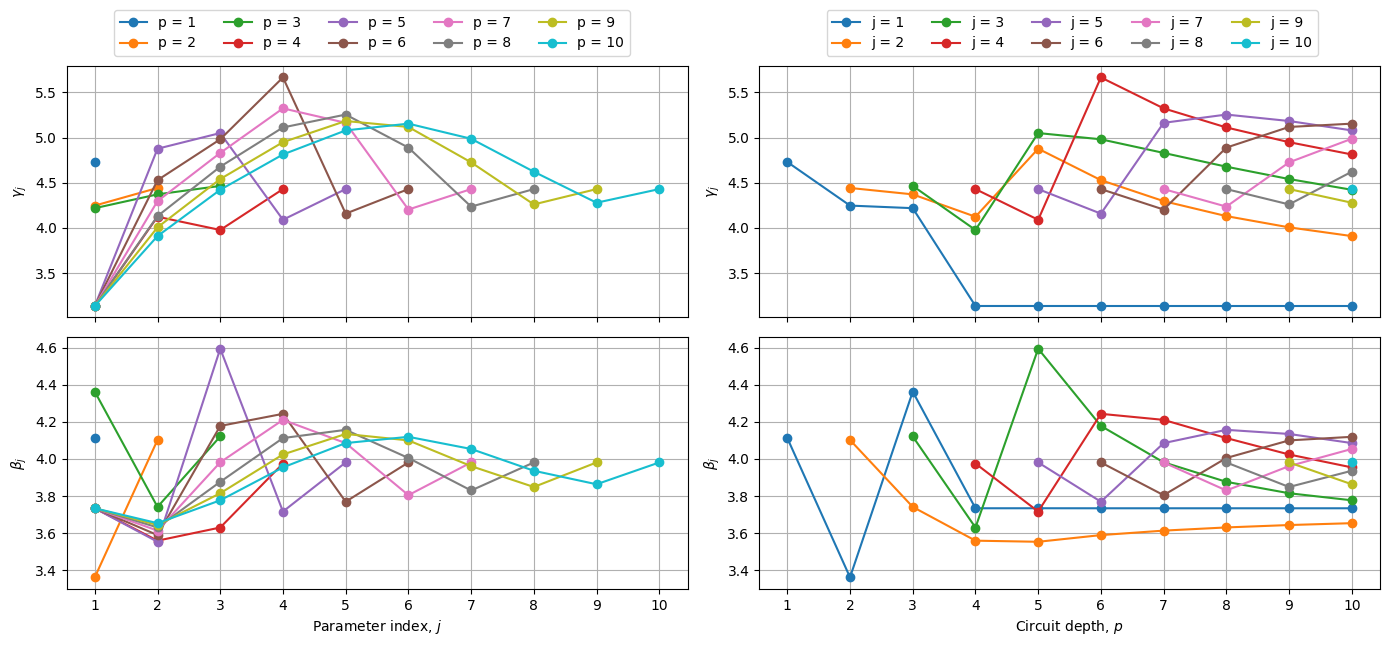

In [23]:
plot_AllOptimalParameters(qaoa_Grover[0.1])

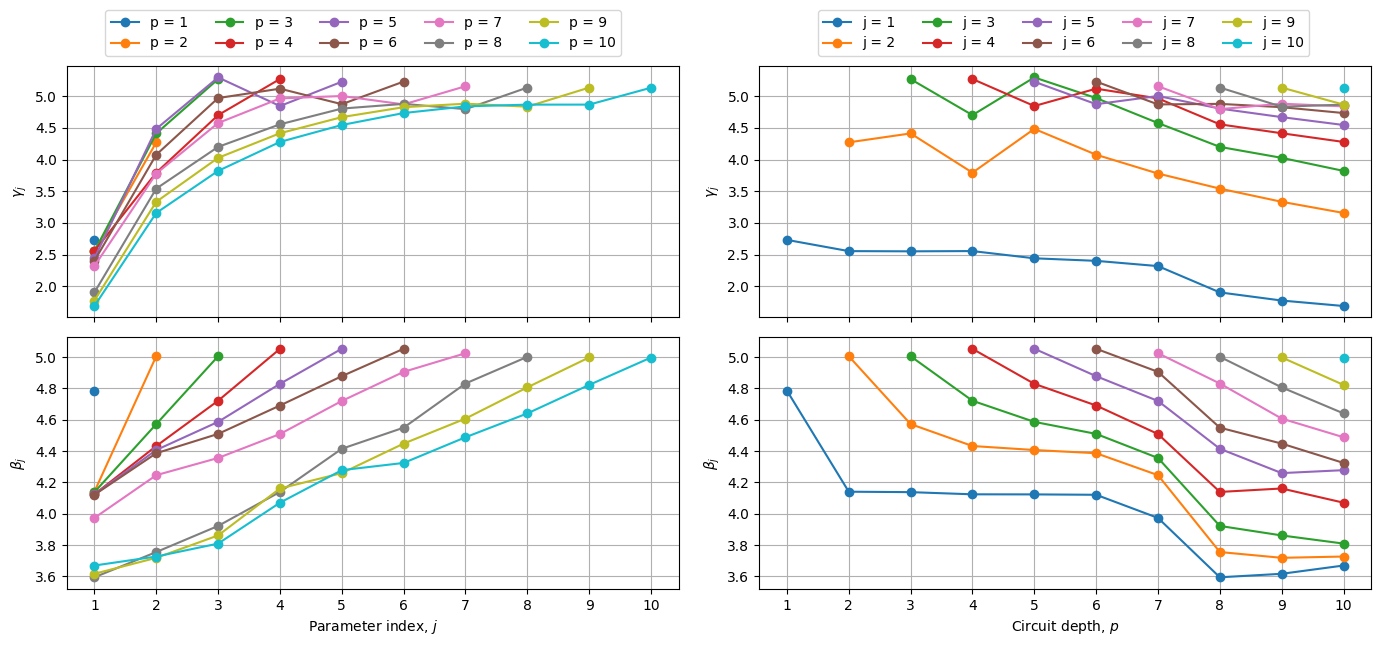

In [29]:
plot_AllOptimalParameters(qaoa_Grover[1])

# Probability of finding opt sol at N shots

In [99]:

qaoas = [qaoa_Grover[1], qaoa_Grover[0.1], 
         qaoa_XYmixer_ring[1], qaoa_XYmixer_ring[0.1],
         qaoa_XYmixer_chain[1], qaoa_XYmixer_chain[0.1],
         qaoa_penalty[1], qaoa_penalty[0.1]]
labels = ["Grover (no CVaR)", "Grover (CVaR=0.1)", 
          "Ring (no CVaR)", "Ring (CVaR=0.1)",
          "Chain (no CVaR)", "Chain (CVaR=0.1)",
          "Penalty (no CVaR)", "Penalty (CVaR=0.1)"]
styles = ["*:m", "*--m", "d:r", "d--r", "x:b", "x--b", "o:g", "o--g"]

hists = []
for qaoa in qaoas:
    hists.append(qaoa.hist(qaoa.get_angles(maxdepth), 2**13))



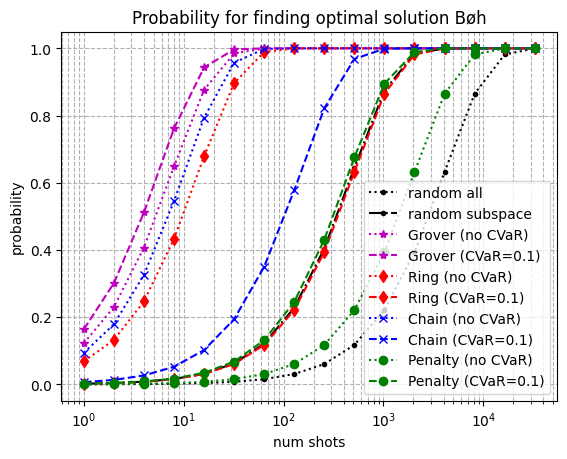

In [ ]:
fig = plt.figure()
for i in range(len(qaoas)):
    plotHitProbabilities_fromHist(hists[i], best_sol, fig=fig, plot_random=(i==0),
                        hamming_weight=budget, 
                        label=labels[i], style=styles[i],
                        max_shots_base2=16)



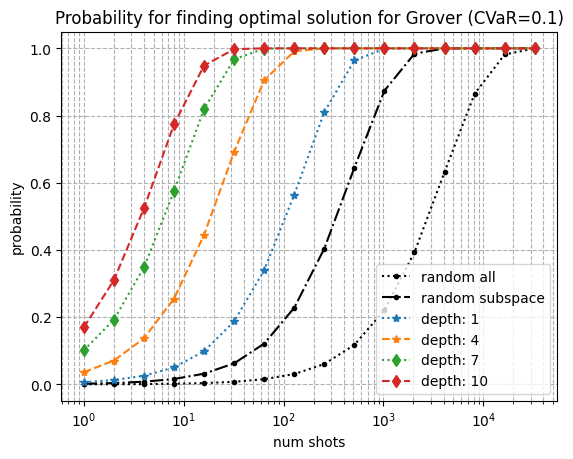

In [116]:
fig = plt.figure()
depths = np.arange(1, maxdepth+1, 3)
for i in range(len(depths)):
    plotHitProbabilities(qaoa_Grover[0.1], best_sol, fig=fig, plot_random=(i==0),
                        hamming_weight=budget, depth = depths[i],
                        label="depth: "+str(depths[i]), style=styles[i][:-1],
                        max_shots_base2=16, title_add_on="for Grover (CVaR=0.1)")



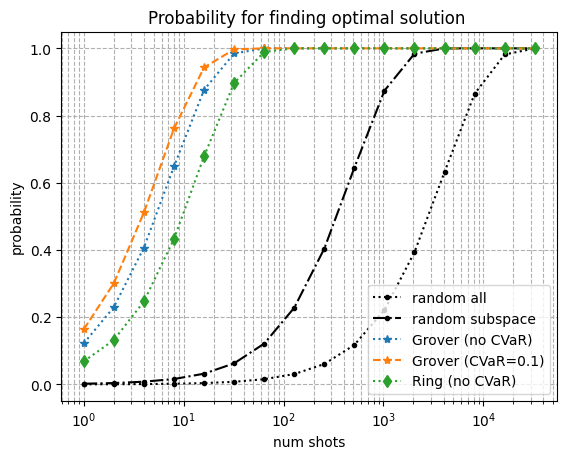

In [112]:
for i in range(3):
    plotHitProbabilities_fromHist(hists[i], best_sol, fig=fig, plot_random=(i==0),
                        hamming_weight=budget, 
                        label=labels[i], style=styles[i][:-1],
                        max_shots_base2=16)